In [7]:
import os, sys

# TODO: set this to the root of the platonic-rep repo on your machine
REPO_ROOT = "/orcd/data/ngk/001/users/gracehu/platonic-rep"

os.chdir(REPO_ROOT)
sys.path.append(REPO_ROOT)

print("CWD:", os.getcwd())

CWD: /orcd/data/ngk/001/users/gracehu/platonic-rep


## imports and config

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tasks import get_models
from utils import to_feature_filename

# ===== Config =====
dataset = "minhuh/prh"
subset = "wit_1024"
modelset = "val"

# language feature extraction options you used
lang_pool = "avg"
lang_prompt = False
caption_idx = 0  # change if you used a different caption index

# vision feature extraction options you used
vision_pool = "cls"
vision_prompt = False

# which DINOv2 model to use on the y-axis
# must be in the vision model list for `modelset`
DINO_NAME = "vit_giant_patch14_dinov2.lvd142m"  # e.g. giant model

# where features + alignment results are stored (defaults from repo)
FEATURE_DIR = "./results/features"
ALIGN_DIR = "./results/alignment"

print("Config OK")


Config OK


## Load model lists and alignment scores

In [11]:
# Get the list of language and vision models in this modelset
llm_models, lvm_models = get_models(modelset, modality="all")

print("Language models:")
for m in llm_models:
    print("  ", m)

print("\nVision models:")
for m in lvm_models:
    print("  ", m)

# Find index of the chosen DINOv2 model
assert DINO_NAME in lvm_models, f"{DINO_NAME} not found in lvm_models"
dino_idx = lvm_models.index(DINO_NAME)
print(f"\nUsing DINOv2 model: {DINO_NAME} (index {dino_idx})")

# Path to the alignment file produced by measure_alignment.py
# Adjust this if your directory structure differs.
align_path = os.path.join(
    ALIGN_DIR,
    dataset,
    modelset,
    f"language_pool-{lang_pool}_prompt-{lang_prompt}_"
    f"vision_pool-{vision_pool}_prompt-{vision_prompt}",
    "mutual_knn_k10.npy",
)

print("Loading alignment from:", align_path)
align_result = np.load(align_path, allow_pickle=True).item()

scores = align_result["scores"]  # shape: [num_llms, num_lvms]
print("Alignment scores shape:", scores.shape)

# Alignment to the chosen DINOv2 model: one scalar per language model
alignment_to_dino = scores[:, dino_idx]
alignment_to_dino

Language models:
   bigscience/bloomz-560m
   bigscience/bloomz-1b1
   bigscience/bloomz-1b7
   bigscience/bloomz-3b
   bigscience/bloomz-7b1
   openlm-research/open_llama_3b
   openlm-research/open_llama_7b
   openlm-research/open_llama_13b
   huggyllama/llama-7b
   huggyllama/llama-13b

Vision models:
   vit_tiny_patch16_224.augreg_in21k
   vit_small_patch16_224.augreg_in21k
   vit_base_patch16_224.augreg_in21k
   vit_large_patch16_224.augreg_in21k
   vit_base_patch16_224.mae
   vit_large_patch16_224.mae
   vit_huge_patch14_224.mae
   vit_small_patch14_dinov2.lvd142m
   vit_base_patch14_dinov2.lvd142m
   vit_large_patch14_dinov2.lvd142m
   vit_giant_patch14_dinov2.lvd142m
   vit_base_patch16_clip_224.laion2b
   vit_large_patch14_clip_224.laion2b
   vit_huge_patch14_clip_224.laion2b
   vit_base_patch16_clip_224.laion2b_ft_in12k
   vit_large_patch14_clip_224.laion2b_ft_in12k
   vit_huge_patch14_clip_224.laion2b_ft_in12k

Using DINOv2 model: vit_giant_patch14_dinov2.lvd142m (index 10)
L

array([0.10644531, 0.11269531, 0.11689453, 0.12119141, 0.13095704,
       0.15537108, 0.15898438, 0.16201171, 0.16113281, 0.15927735])

## Load bits-per-byte and compute language performance

In [12]:
bpb_list = []

for m in llm_models:
    # Build feature filename for each language model
    feat_path = to_feature_filename(
        FEATURE_DIR,
        dataset,
        subset,
        m,
        pool=lang_pool,
        prompt=lang_prompt,
        caption_idx=caption_idx,
    )

    if not os.path.exists(feat_path):
        raise FileNotFoundError(f"Feature file not found for {m} at {feat_path}")

    data = torch.load(feat_path, map_location="cpu")

    if "bpb" not in data:
        raise KeyError(f"'bpb' not found in feature file for {m}")

    bpb_value = data["bpb"].item()
    bpb_list.append(bpb_value)
    print(f"{m}: bpb = {bpb_value:.4f}")

bpb = np.array(bpb_list)

# Language performance metric = 1 - bits-per-byte (as in the paper)
lang_perf = 1.0 - bpb

print("\nLanguage performance (1 - bpb):")
for m, p in zip(llm_models, lang_perf):
    print(f"{m}: {p:.4f}")

bigscience/bloomz-560m: bpb = 2.0766
bigscience/bloomz-1b1: bpb = 1.8847
bigscience/bloomz-1b7: bpb = 1.9390
bigscience/bloomz-3b: bpb = 1.8948
bigscience/bloomz-7b1: bpb = 1.8394
openlm-research/open_llama_3b: bpb = 1.7194
openlm-research/open_llama_7b: bpb = 1.6774
openlm-research/open_llama_13b: bpb = 1.6558
huggyllama/llama-7b: bpb = 1.6477
huggyllama/llama-13b: bpb = 1.6205

Language performance (1 - bpb):
bigscience/bloomz-560m: -1.0766
bigscience/bloomz-1b1: -0.8847
bigscience/bloomz-1b7: -0.9390
bigscience/bloomz-3b: -0.8948
bigscience/bloomz-7b1: -0.8394
openlm-research/open_llama_3b: -0.7194
openlm-research/open_llama_7b: -0.6774
openlm-research/open_llama_13b: -0.6558
huggyllama/llama-7b: -0.6477
huggyllama/llama-13b: -0.6205


# Plot language performance vs vision alignment

## Make the scatter plot (performance vs alignment to DINOv2)

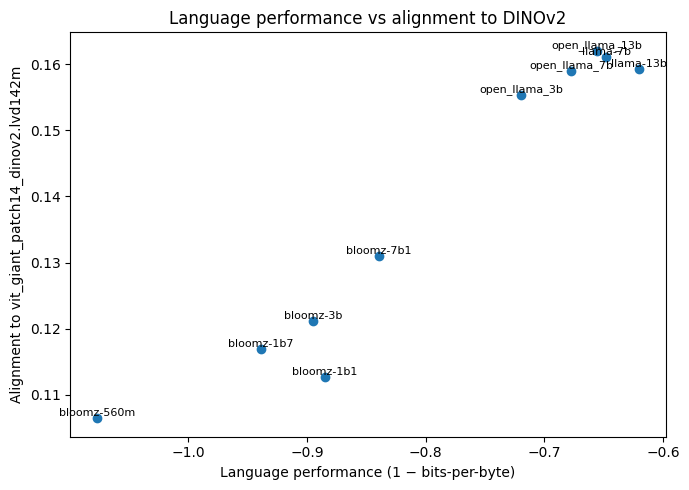

In [16]:
plt.figure(figsize=(7, 5))

plt.scatter(lang_perf, alignment_to_dino)

# optional: label each point with a short model name
for x, y, name in zip(lang_perf, alignment_to_dino, llm_models):
    short_name = name.split("/")[-1]  # strip HF org if present
    plt.text(x, y, short_name, fontsize=8, ha="center", va="bottom")

plt.xlabel("Language performance (1 − bits-per-byte)")
plt.ylabel(f"Alignment to {DINO_NAME}")
plt.title("Language performance vs alignment to DINOv2")
plt.tight_layout()
plt.show()

## align to any vision model

In [17]:

def plot_alignment_to_vision(
    vision_model_name: str,
    llm_models,
    lvm_models,
    scores: np.ndarray,
    lang_perf: np.ndarray,
    annotate: bool = True,
    figsize=(7, 5),
):
    """
    Plot language performance vs alignment to a given vision model.

    Args:
        vision_model_name: Name of the vision model as in lvm_models.
        llm_models: List of language model names (len = num_llms).
        lvm_models: List of vision model names (len = num_lvms).
        scores: Alignment matrix of shape (num_llms, num_lvms),
                e.g. mutual_knn scores from measure_alignment.py.
        lang_perf: 1D array of shape (num_llms,), e.g. 1 - bpb.
        annotate: If True, label each point with a short LM name.
        figsize: Figure size for the plot.
    """
    if vision_model_name not in lvm_models:
        # try to be helpful: show close matches
        candidates = [m for m in lvm_models if vision_model_name in m or m in vision_model_name]
        msg = f"{vision_model_name!r} not found in lvm_models."
        if candidates:
            msg += f" Did you mean one of: {candidates}?"
        raise ValueError(msg)

    v_idx = lvm_models.index(vision_model_name)
    alignment = scores[:, v_idx]  # alignment to this vision model for each LM

    plt.figure(figsize=figsize)
    plt.scatter(lang_perf, alignment)

    if annotate:
        for x, y, name in zip(lang_perf, alignment, llm_models):
            short_name = name.split("/")[-1]  # strip HF org if present
            plt.text(x, y, short_name, fontsize=8, ha="center", va="bottom")

    plt.xlabel("Language performance (1 − bits-per-byte)")
    plt.ylabel(f"Alignment to {vision_model_name}")
    plt.title(f"LM performance vs alignment to {vision_model_name}")
    plt.tight_layout()
    plt.show()

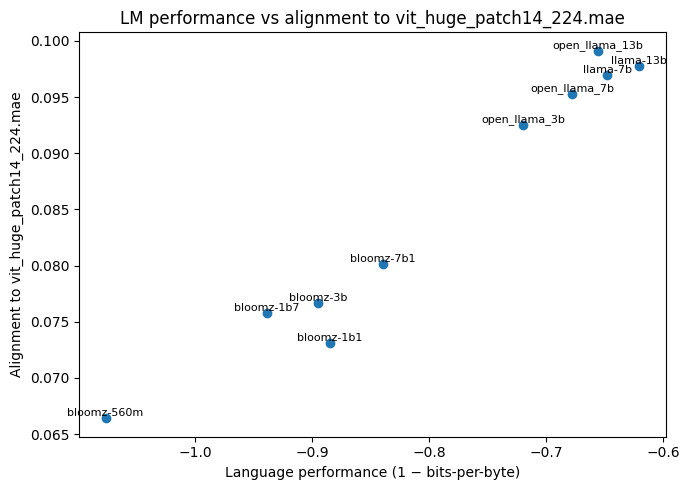

In [15]:
# or CLIP ViT-B/32 if it's in your modelset
plot_alignment_to_vision(
    "vit_huge_patch14_224.mae",
    llm_models,
    lvm_models,
    scores,
    lang_perf,
)